In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.001

In [4]:
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

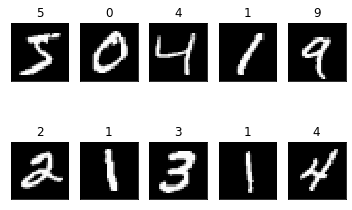

In [5]:
fig = plt.figure()
 
for i in range(10):
    # 2x5 그리드에 i+1번째 subplot을 추가하고 얻어옴
    subplot = fig.add_subplot(2, 5, i + 1)

    # x, y 축의 지점 표시를 안함
    subplot.set_xticks([])
    subplot.set_yticks([])

    # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
    subplot.set_title('%d' % train_dataset[i][1])

    # 입력으로 사용한 i번째 테스트 이미지를 28x28로 재배열하고
    # 이 2차원 배열을 그레이스케일 이미지로 출력
    subplot.imshow(train_dataset[i][0].squeeze().numpy(), cmap='gray')

plt.show()

In [10]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out) #0~9 10dim 
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [13]:
# Train the model
for epoch in range(num_epochs):
    train_loss = []
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
       
        loss.backward()
       
        optimizer.step()
        train_loss.append(loss.item())
    
    print ('Epoch [{}/{}], Loss: {:.4f}' 
           .format(epoch+1, num_epochs, sum(train_loss)/len(train_loss)))
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images) # [batch, 10(확률값 어떤것이 가장 큰 확률을 가지냐)]
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Epoch [1/5], Loss: 2.2777
Accuracy of the network on the test images: 46.6 %
Epoch [2/5], Loss: 2.2257
Accuracy of the network on the test images: 60.99 %
Epoch [3/5], Loss: 2.1415
Accuracy of the network on the test images: 64.88 %
Epoch [4/5], Loss: 1.9926
Accuracy of the network on the test images: 68.41 %


KeyboardInterrupt: 

In [14]:
bad_prediction = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                bad_prediction.append([images[i].numpy(), predicted[i], labels[i]])

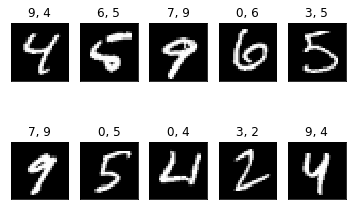

In [15]:
fig = plt.figure()
 
for i in range(10):
    # 2x5 그리드에 i+1번째 subplot을 추가하고 얻어옴
    subplot = fig.add_subplot(2, 5, i + 1)

    # x, y 축의 지점 표시를 안함
    subplot.set_xticks([])
    subplot.set_yticks([])

    # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
    subplot.set_title(f'{bad_prediction[i][1]}, {bad_prediction[i][2]}')

    # 입력으로 사용한 i번째 테스트 이미지를 28x28로 재배열하고
    # 이 2차원 배열을 그레이스케일 이미지로 출력
    subplot.imshow(bad_prediction[i][0].reshape(28, 28), cmap='gray')

plt.show()